# Import

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split

# import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

## Import Data

In [2]:
class CTDataset(Dataset):
	def __init__(self, filepath):
		self.x, self.y = torch.load(filepath)
		self.x = self.x / 255.0
		self.y = nn.functional.one_hot(self.y, num_classes=10).to(float)

	def __len__(self):
		return self.x.shape[0]

	def __getitem__(self, ix):
		return self.x[ix], self.y[ix]

In [3]:
# https://www.di.ens.fr/~lelarge/MNIST.tar.gz
train_ds = CTDataset("./MNIST/training.pt")
# test_ds = CTDataset('./MNIST/test.pt')

In [4]:
train, dev, valid = random_split(train_ds, [0.6, 0.2, 0.2])

In [5]:
train_size = min(1_000, len(train)) # Check if model overfits on small data, to ensure DNN actually is effective
dev_size = min(1_000, len(dev))

min_training_batches = 4
train_batch_size = min(32, max(1, train_size // min_training_batches))

evaluation_batch_size = min(1_024, dev_size)

In [6]:
train_random_sampler = RandomSampler(train, num_samples=train_size)
dev_random_sampler = RandomSampler(dev, num_samples=dev_size)

train_dl = DataLoader(
	train, sampler=train_random_sampler, batch_size=train_batch_size, drop_last=True
)

dev_dl = DataLoader(
	dev, sampler=dev_random_sampler, batch_size=evaluation_batch_size, drop_last=True
)

## Train

In [7]:
class NeuralNet(nn.Module):
	def __init__(self, init_dl, hidden_layers):
		super().__init__()

		for x, y in init_dl:
			break

		self.input_size = x.shape[-1]
		self.output_size = y.shape[-1]

		# input_layer = 
		
		
		output_layer = nn.LazyLinear(self.output_size) # output layer
		
		layers = (
      		# [input_layer] +
			hidden_layers +
			[output_layer]
		)

		self.network = nn.Sequential(
			*layers
		)

		# init lazy layers
		self.forward(x)

	def reshape(self, x):
		# batch_size, no_of_channels, width, height
		return x.view(x.shape[0], 1, x.shape[1], x.shape[2])

	def forward(self, x):
		return self.network(self.reshape(x)).squeeze()

In [8]:
def get_max_len(arrays):
	return max(
		[
			len(array)
			for array
			in arrays
		]
	)

def pad(array, max_len):
	return list(np.pad(
		array,
		pad_width = (0, max_len-len(array)),
		constant_values = np.nan
	))

# @torch.compile(mode="reduce-overhead")
def train_batch(model, optimizer, loss, x, y, train_dl_len, batch_idx, accum_iter=1, k_frac=None):
	# x = x.half()
	# y = y.half()
	
	model.train()
	with torch.set_grad_enabled(True): # turn on history tracking
		# forward pass
		proba = model(x)
		loss_array = loss(proba, y)

		loss_scalar = loss_array.mean()
	
	# backward pass
	optimizer.zero_grad(set_to_none=True)
	loss_scalar.backward()

	# weights update
	# if accum_iter != 1 -> gradient accumulation
	batch_num = batch_idx + 1
	if (
		(batch_num % accum_iter == 0)
		or
		(batch_num == len(train_dl_len))
	):
		optimizer.step()

# @torch.compile(mode="reduce-overhead")
def train_epoch(dl, model, optimizer, loss, train_dl_len, k_frac=None):

	epoch_accuracies = []
	for batch_idx, (x, y) in enumerate(dl):
		train_batch(model, optimizer, loss, x, y, train_dl_len, batch_idx, accum_iter=1, k_frac=k_frac)
	
		epoch_accuracies += eval_batch(model, x, y)

	return epoch_accuracies

# @torch.compile(mode="reduce-overhead")
def eval_batch(model, x, y):
	# x = x.half()
	# y = y.half()

	model.eval()
	with torch.set_grad_enabled(False): # turn off history tracking
		# forward pass
		proba = model(x)
		
		true = y.argmax(axis=1)
		pred = proba.argmax(axis=1)

		epoch_accuracy_array = (pred == true) # torch.sum()

		# epoch_loss_array = loss_value.detach() # loss_value.item() # batch loss

		return epoch_accuracy_array

# @torch.compile(mode="reduce-overhead")
def eval_epoch(dl, model):
	epoch_accuracies = []
	for batch_idx, (x, y) in enumerate(dl):
		epoch_accuracies += eval_batch(model, x, y)

	return epoch_accuracies


def train_model(train_dl, dev_dl, model, loss, optimizer, n_epochs, eval_every=5, k_frac=None, agg=["mean"]):
	model.train()
  
	summary_list = []
  
	train_dl_len = len(train_dl)

	for epoch in range(1, n_epochs + 1):
		epoch_train_accuracies = train_epoch(train_dl, model, optimizer, loss, train_dl_len, k_frac)
		
		if epoch % eval_every == 0:
			epoch_dev_accuracies = eval_epoch(dev_dl, model)
		else:
			epoch_dev_accuracies = []
		
		for e in epoch_train_accuracies:
			summary_list.append(
				[epoch, "Train", float(e)]
			)
		for e in epoch_dev_accuracies:
			summary_list.append(
				[epoch, "Dev", float(e)]
			)

		print(f"Epoch {epoch}/{n_epochs} Completed")

	model.eval()

	summary = (
	 	pd.DataFrame(
			columns = ["Epoch", "Subset", "Accuracy"],
			data = summary_list
		)
	)
 
	if agg:
		summary = (
			summary
			.groupby(["Epoch", "Subset"])
			.agg(["mean"])
		)
		summary.columns = list(map('_'.join, summary.columns.values))
		summary = (
			summary
			.reset_index()
			.pivot(
				index="Epoch",
				columns="Subset",
				# values = "Accuracy"
			)
		)
		summary.columns = list(map('_'.join, summary.columns.values))
		summary = summary.reset_index()
	return summary

In [9]:
model = NeuralNet(
	train_dl,
	hidden_layers = [
		nn.Flatten(),
		nn.LazyLinear(100),
		nn.ReLU(),
		nn.LazyLinear(10),
		nn.ReLU()
		# nn.Sigmoid() not required
	]
)
# model = model.half()
# model = torch.compile(model, mode="reduce-overhead")

/Users/ahmedthahir/anaconda3/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [10]:
# optim_class = torch.optim
# optim_children = dir(optim_class)
# no_of_optimizers = [o.startswith("_") for o in optim_children].index(True)
# optimizers = optim_children[:no_of_optimizers]
# optimizers = [o for o in optimizers if o != "Optimizer"]

# for optimizer in optimizers:
#     print(getattr(optim_class, optimizer)(model.parameters(), lr=0.01))

In [11]:
loss = nn.CrossEntropyLoss(reduction="none")

In [12]:
# this is our project
optimizer = SGD(model.parameters(), lr=0.1)
n_epochs = 20 # 3

In [13]:
summary = train_model(
	train_dl,
	dev_dl,
	model,
	loss,
	optimizer,
	n_epochs,
	eval_every=5,
	agg = ["mean"]
)

Epoch 1/20 Completed
Epoch 2/20 Completed
Epoch 3/20 Completed
Epoch 4/20 Completed
Epoch 5/20 Completed
Epoch 6/20 Completed
Epoch 7/20 Completed
Epoch 8/20 Completed
Epoch 9/20 Completed
Epoch 10/20 Completed
Epoch 11/20 Completed
Epoch 12/20 Completed
Epoch 13/20 Completed
Epoch 14/20 Completed
Epoch 15/20 Completed
Epoch 16/20 Completed
Epoch 17/20 Completed
Epoch 18/20 Completed
Epoch 19/20 Completed
Epoch 20/20 Completed


In [14]:
def plot_summary(df, percentage=True):
	x = df.columns[0]
	y = df.columns[1:]

	if percentage:
		df[y] *= 100

	fig = px.line(
		data_frame=df,
		x=x,
		y=y,
		title="Loss Curve: Accuracy (Higher is better)",
		range_x=[df[x].values.min(), df[x].values.max()],
		range_y=[0, 100 if percentage else 1], # df[y].values.min() * 0.95
		markers=True,
	)
	fig.update_layout(xaxis_title="Epoch", yaxis_title="Accuracy")
	fig.update_traces(
		patch={
			"marker": {"size": 5},
			"line": {
				"width": 1,
				# "dash": "dot"
			},
		}
	)
	fig.update_traces(connectgaps=True) # required for connecting dev accuracies
 
	fig.show()

plot_summary(summary)

## Test

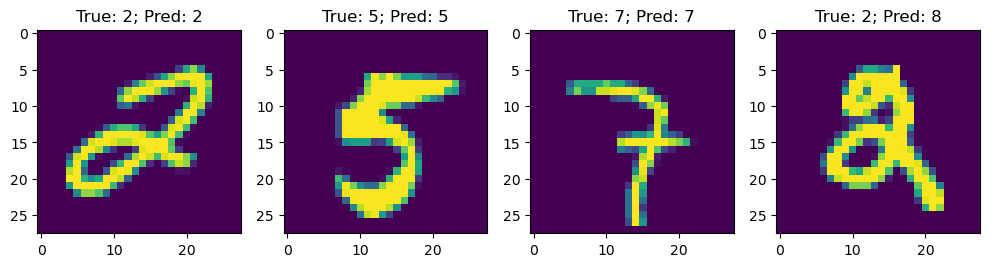

In [15]:
def plot_examples(data, plot_count=4, fig_size=(10, 5)):
	x, y = data[:plot_count]
	# x = x.half()
	# y = y.half()
	
	pred = model(x).argmax(axis=1)
	cols = 4
	rows = np.ceil(plot_count / cols).astype(int)

	fig, ax = plt.subplots(rows, cols, figsize=fig_size)
	for i in range(plot_count):
		plt.subplot(rows, cols, i + 1)
		plt.imshow(x[i])
		plt.title(f"True: {y[i].argmax()}; Pred: {pred[i]}")
	fig.tight_layout()
	plt.show()

plot_examples(dev, 4)